In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from tqdm import tqdm
from natsort import natsorted
import os
from visualizations import Umap, K_means, TsnePlot, save_image
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import numpy as np
import cv2
# import pdb
import config
from glob import glob
import tensorflow as tf

# import lpips
import torch.nn as nn
from torchvision.models import resnet18
from torchsummary import summary

# from pytorch_metric_learning import miners, losses


2023-04-30 20:02:26.802670: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 20:02:27.402701: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
torch.cuda.is_available()

True

In [3]:
np.random.seed(45)
torch.manual_seed(45)

In [4]:
class EEGDataset(Dataset):
    def __init__(self, eegs, labels, subjects=None, n_fft=64, win_length=64, hop_length=16):
        self.eegs         = eegs
        # self.images       = images
        self.labels       = labels
        # self.subjects     = subjects


    def __getitem__(self, index):
        eeg    = self.eegs[index]
        # eeg    = np.float32(self.eegs[index].cpu())
        norm   = torch.max(eeg) / 2.0
        eeg    = (eeg - norm)/ norm
        # eeg    = (eeg - np.min(eeg))/ (np.max(eeg) - np.min(eeg))
        # image  = self.images[index]
        label  = self.labels[index]
        # subject= self.subjects[index]
        return eeg, label

    def __len__(self):
        return len(self.eegs)


In [5]:

import pandas as pd
if __name__ == '__main__':

    base_path       = config.base_path
    train_path      = config.train_path
    validation_path = config.validation_path
    test_path = config.test_path
    device          = config.device
    batch_size = config.batch_size
    print(device)


    x_train_eeg = []
    x_train_image = []
    labels = []

    data_ = pd.DataFrame(columns=['EEG','Label',"ID",'Subject'])

    for i in tqdm(natsorted(os.listdir(base_path + train_path))):
        loaded_array = np.load(base_path + train_path + i, allow_pickle=True)
        data_= data_.append(pd.DataFrame(loaded_array[1:].reshape(1,4),columns=['EEG','Label',"ID",'Subject']),ignore_index=True)
        # x_train_eeg.append(np.expand_dims(loaded_array[1].T, axis=0))
        # img = cv2.resize(loaded_array[0], (224, 224))
        # img = np.transpose(img, (2, 0, 1))
        # x_train_image.append(img)
        # labels.append(loaded_array[2])
        # train_subjects.append(loaded_array[4])


cuda


100%|██████████| 7959/7959 [00:05<00:00, 1518.80it/s]


In [6]:
d={}
for i in range(1,7):
    d['subject'+str(i)]= data_.iloc[np.where(data_['Subject']==i)]

In [7]:
from sklearn.model_selection import train_test_split
X_train = []
X_pool= []
y_train = []
y_pool = []
for i in range(1,7):
    X_tr, X_p, y_tr, y_p= train_test_split(np.array(d['subject'+str(i)]['EEG']),np.array(d['subject'+str(i)]['Label']),test_size=0.03,stratify=d['subject'+str(i)]['Label'])
    X_train.append(X_tr)
    X_pool.append(X_p)
    y_train.append(y_tr)
    y_pool.append(y_p)

In [8]:
X_train = [num for sublist in X_train for num in sublist]
X_train =[num.T for num in X_train]
X_pool = [num for sublist in X_pool for num in sublist]
X_pool =[num.T for num in X_pool]
y_train = [num for sublist in y_train for num in sublist]
y_pool = [num for sublist in y_pool for num in sublist]



In [9]:
X_train = np.array(X_train)
X_pool=np.array(X_pool)
y_pool= np.array(y_pool)
y_train= np.array(y_train)

In [10]:
x_train_eeg = torch.from_numpy(X_train).float().to(device)
train_labels = torch.from_numpy(y_train).long().to(device)
x_pool_eeg = torch.from_numpy(X_pool).float().to(device)
pool_labels = torch.from_numpy(y_pool).long().to(device)

In [11]:
print(x_train_eeg.shape)

torch.Size([7719, 440, 128])


In [12]:
class EEGFeatNet(nn.Module):
    def __init__(self, input_shape=(1, 440, 128), n_features=128, projection_dim=128, num_filters=[128, 256, 512, 1024], kernel_sizes=[3, 3, 3, 3], strides=[2, 2, 2, 2], padding=[1, 1, 1, 1]):
        super(EEGFeatNet, self).__init__()

        # Define the convolutional layers
        self.layers = nn.ModuleList()
        in_channels = input_shape[0]
        for i, out_channels in enumerate(num_filters):
            self.layers.append( 
                                nn.Sequential(
                                    nn.Conv2d(in_channels, out_channels, kernel_sizes[i], strides[i], padding[i], bias=False),\
                                    # nn.BatchNorm2d(out_channels),\
                                    nn.InstanceNorm2d(out_channels),\
                                    nn.LeakyReLU(),
                                    nn.Dropout(p=0.05),
                                )
                             )
            in_channels = out_channels

        self.layers.append(nn.AdaptiveAvgPool2d(output_size=(1, 1)))

        # Define the fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(num_filters[-1], projection_dim, bias=False),
            # nn.LeakyReLU(inplace=True),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(projection_dim,out_features=40, bias=False),
        #     # nn.LeakyReLU(inplace=True),
        )

    def forward(self, x):
        # Apply the convolutional layers
        for layer in self.layers:
            x = layer(x)
            # print(x.shape)

        # Flatten the output
        x = torch.reshape(x, [x.shape[0], -1])
        # print(x.shape)

        # Apply the fully connected layers
        proj = self.fc(x)
        x= self.fc2(proj)
        return x,proj

In [13]:
x_val_eeg = []
x_val_image = []
label_Val = []
val_subjects = []

for i in tqdm(natsorted(os.listdir(base_path + validation_path))):
    loaded_array = np.load(base_path + validation_path + i, allow_pickle=True)
    # x_val_eeg.append(loaded_array[1].T)
    x_val_eeg.append(np.expand_dims(loaded_array[1].T, axis=0))
    img = cv2.resize(loaded_array[0], (224, 224))
    img = (cv2.cvtColor(img, cv2.COLOR_BGR2RGB) - 127.5) / 127.5
    img = np.transpose(img, (2, 0, 1))
    x_val_image.append(img)
    label_Val.append(loaded_array[2])
    val_subjects.append(loaded_array[4])
    
x_val_eeg   = np.array(x_val_eeg)
val_labels  = np.array(label_Val)

x_val_eeg   = torch.from_numpy(x_val_eeg).float().to(device)
val_labels  = torch.from_numpy(val_labels).long().to(device)

val_data       = EEGDataset(x_val_eeg, val_labels)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False, pin_memory=False, drop_last=True)

100%|██████████| 1994/1994 [00:01<00:00, 1063.32it/s]


In [14]:
x_test_eeg = []
x_test_image = []
label_Test = []
test_subjects = []

for i in tqdm(natsorted(os.listdir(base_path + test_path))):
    loaded_array = np.load(base_path + test_path + i, allow_pickle=True)
    # x_val_eeg.append(loaded_array[1].T)
    x_test_eeg.append(np.expand_dims(loaded_array[1].T, axis=0))
    img = cv2.resize(loaded_array[0], (224, 224))
    img = (cv2.cvtColor(img, cv2.COLOR_BGR2RGB) - 127.5) / 127.5
    img = np.transpose(img, (2, 0, 1))
    x_test_image.append(img)
    label_Test.append(loaded_array[2])
    test_subjects.append(loaded_array[4])
    
x_test_eeg   = np.array(x_test_eeg)
test_labels  = np.array(label_Test)

x_test_eeg   = torch.from_numpy(x_test_eeg).float().to(device)
test_labels  = torch.from_numpy(test_labels).long().to(device)

test_data       = EEGDataset(x_test_eeg, test_labels)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False, pin_memory=False, drop_last=True)

100%|██████████| 1987/1987 [00:01<00:00, 1018.66it/s]


In [15]:
def train(epoch, model, optimizer, loss_fn, x_train_eeg,train_labels):
    # print(x_train_eeg.shape,train_labels.shape)
    train_data  = EEGDataset(x_train_eeg, train_labels)
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=False, drop_last=True)

    running_loss      = []
    eeg_featvec_proj  = np.array([])
    labels_array      = np.array([])

    tq = tqdm(train_dataloader)
    for batch_idx, (eeg, labels) in enumerate(tq, start=1):
        eeg    = eeg.to(config.device)
        labels = labels.to(config.device)
        # print(eeg.shape)
        optimizer.zero_grad()
        y_pred,proj = model(eeg.reshape(256,1,440,128))

        loss       = loss_fn(y_pred, labels)
        
        # backpropagate and update parameters
        loss.backward()
        optimizer.step()

        running_loss = running_loss + [loss.detach().cpu().numpy()]

        tq.set_description('Train:[{}, {:0.3f}]'.format(epoch, np.mean(running_loss)))

    if (epoch%config.vis_freq) == 0:
        # for batch_idx, (eeg, eeg_x1, eeg_x2, gamma, images, labels) in enumerate(tqdm(train_dataloader)):
        for batch_idx, (eeg, labels) in enumerate(tqdm(train_dataloader)):
            eeg, labels = eeg.to(config.device), labels.to(config.device)
            with torch.no_grad():
                x_proj,proj = model(eeg.reshape(256,1,440,128))
            # eeg_featvec      = np.concatenate((eeg_featvec, x.cpu().detach().numpy()), axis=0) if eeg_featvec.size else x.cpu().detach().numpy()
            eeg_featvec_proj = np.concatenate((eeg_featvec_proj, x_proj.cpu().detach().numpy()), axis=0) if eeg_featvec_proj.size else x_proj.cpu().detach().numpy()
            # eeg_gamma        = np.concatenate((eeg_gamma, gamma.cpu().detach().numpy()), axis=0) if eeg_gamma.size else gamma.cpu().detach().numpy()
            labels_array     = np.concatenate((labels_array, labels.cpu().detach().numpy()), axis=0) if labels_array.size else labels.cpu().detach().numpy()
    acc = (torch.argmax(torch.tensor(eeg_featvec_proj), 1) == torch.tensor(labels_array)).float().mean()
    print("[Epoch: {}, train Accuracy: {}]".format(epoch, acc))
    return np.mean(running_loss)

In [16]:
def validation(epoch, model, optimizer, loss_fn, val_dataloader):

	running_loss      = []
	eeg_featvec_proj  = np.array([])
	labels_array      = np.array([])

	tq = tqdm(val_dataloader)
	for batch_idx, (eeg, labels) in enumerate(tq, start=1):
		eeg, labels = eeg.to(config.device), labels.to(config.device)
		with torch.no_grad():
			model.eval()
			x_proj,proj = model(eeg.reshape(256,1,440,128))

			# hard_pairs = miner(x_proj, labels)
			loss       = loss_fn(x_proj, labels)

			running_loss = running_loss + [loss.detach().cpu().numpy()]

		tq.set_description('Val:[{}, {:0.3f}]'.format(epoch, np.mean(running_loss)))

		eeg_featvec_proj = np.concatenate((eeg_featvec_proj, x_proj.cpu().detach().numpy()), axis=0) if eeg_featvec_proj.size else x_proj.cpu().detach().numpy()
		labels_array     = np.concatenate((labels_array, labels.cpu().detach().numpy()), axis=0) if labels_array.size else labels.cpu().detach().numpy()

	acc = (torch.argmax(torch.tensor(eeg_featvec_proj), 1) == torch.tensor(labels_array)).float().mean()
	print("[Epoch: {}, Val Accuracy: {}]".format(epoch, acc))

	return np.mean(running_loss), acc

In [17]:
def test_fn(epoch, model, optimizer, loss_fn, test_dataloader):

	running_loss      = []
	eeg_featvec_proj  = np.array([])
	eeg_featvec_proj_actual=np.array([])
	labels_array      = np.array([])

	tq = tqdm(test_dataloader)
	for batch_idx, (eeg, labels) in enumerate(tq, start=1):
		eeg, labels = eeg.to(config.device), labels.to(config.device)
		with torch.no_grad():
			x_proj,proj = model(eeg.reshape(1,1,440,128))

			# hard_pairs = miner(x_proj, labels)
			loss       = loss_fn(x_proj, labels)

			running_loss = running_loss + [loss.detach().cpu().numpy()]

		tq.set_description('Val:[{}, {:0.3f}]'.format(epoch, np.mean(running_loss)))

		eeg_featvec_proj = np.concatenate((eeg_featvec_proj, x_proj.cpu().detach().numpy()), axis=0) if eeg_featvec_proj.size else x_proj.cpu().detach().numpy()
		eeg_featvec_proj_actual = np.concatenate((eeg_featvec_proj_actual, proj.cpu().detach().numpy()), axis=0) if eeg_featvec_proj_actual.size else proj.cpu().detach().numpy()
		labels_array     = np.concatenate((labels_array, labels.cpu().detach().numpy()), axis=0) if labels_array.size else labels.cpu().detach().numpy()
	
	# num_clusters   = 40
	# k_means        = K_means(n_clusters=num_clusters)
	# clustering_acc_proj = k_means.transform(eeg_featvec_proj_actual, labels_array)
	# tsne_plot = TsnePlot(perplexity=30, learning_rate=700, n_iter=1000)
	# reduced_embedding_tsne = tsne_plot.plot(eeg_featvec_proj_actual, labels_array, clustering_acc_proj, 'test', 2,epoch, proj_type='proj')
	acc = (torch.argmax(torch.tensor(eeg_featvec_proj), 1) == torch.tensor(labels_array)).float().mean()
	print("[Epoch: {}, Val Accuracy: {}]".format(epoch, acc))
	return np.mean(running_loss), acc

In [18]:
model     = EEGFeatNet(input_shape=config.input_shape, n_features=config.feat_dim, projection_dim=config.projection_dim).to(config.device)

summary(model,(1,440,128))
model     = torch.nn.DataParallel(model).to(config.device)

optimizer = torch.optim.Adam(\
                                    list(model.parameters()),\
                                    lr=config.lr,\
                                    betas=(0.9, 0.999)
                                )
loss_fn  = nn.CrossEntropyLoss()
EPOCHS = config.epoch



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 128, 220, 64]           1,152
    InstanceNorm2d-2         [-1, 128, 220, 64]               0
         LeakyReLU-3         [-1, 128, 220, 64]               0
           Dropout-4         [-1, 128, 220, 64]               0
            Conv2d-5         [-1, 256, 110, 32]         294,912
    InstanceNorm2d-6         [-1, 256, 110, 32]               0
         LeakyReLU-7         [-1, 256, 110, 32]               0
           Dropout-8         [-1, 256, 110, 32]               0
            Conv2d-9          [-1, 512, 55, 16]       1,179,648
   InstanceNorm2d-10          [-1, 512, 55, 16]               0
        LeakyReLU-11          [-1, 512, 55, 16]               0
          Dropout-12          [-1, 512, 55, 16]               0
           Conv2d-13          [-1, 1024, 28, 8]       4,718,592
   InstanceNorm2d-14          [-1, 1024

In [19]:
x_train_eeg.shape

torch.Size([7719, 440, 128])

In [20]:
from torchviz import make_dot

make_dot(model(x_train_eeg[0].reshape(1,1,440,128)), params=dict(list(model.named_parameters()))).render("rnn_torchviz", format="png")

'rnn_torchviz.png'

In [21]:
train_losses = []
val_losses = []
val_accs=[]
for epoch in range(0, EPOCHS):
        running_train_loss = train(epoch, model, optimizer, loss_fn, x_train_eeg, train_labels)
        running_val_loss,acc = validation(epoch, model, optimizer, loss_fn, val_dataloader)
        train_losses.append(running_train_loss)
        val_losses.append(running_val_loss)
        val_accs.append(acc)

100%|██████████| 30/30 [00:01<00:00, 20.29it/s]


[Epoch: 0, train Accuracy: 0.04661458358168602]


Val:[0, 3.655]: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


[Epoch: 0, Val Accuracy: 0.05078125]


100%|██████████| 30/30 [00:01<00:00, 22.59it/s]


[Epoch: 1, train Accuracy: 0.11874999850988388]


Val:[1, 3.555]: 100%|██████████| 7/7 [00:00<00:00, 22.30it/s]


[Epoch: 1, Val Accuracy: 0.0870535746216774]


100%|██████████| 30/30 [00:01<00:00, 22.26it/s]


[Epoch: 2, train Accuracy: 0.13502603769302368]


Val:[2, 3.305]: 100%|██████████| 7/7 [00:00<00:00, 21.90it/s]


[Epoch: 2, Val Accuracy: 0.1099330335855484]


100%|██████████| 30/30 [00:01<00:00, 22.60it/s]


[Epoch: 3, train Accuracy: 0.2506510317325592]


Val:[3, 3.016]: 100%|██████████| 7/7 [00:00<00:00, 21.33it/s]


[Epoch: 3, Val Accuracy: 0.1975446492433548]


100%|██████████| 30/30 [00:01<00:00, 22.61it/s]


[Epoch: 4, train Accuracy: 0.26119792461395264]


Val:[4, 2.751]: 100%|██████████| 7/7 [00:00<00:00, 21.44it/s]


[Epoch: 4, Val Accuracy: 0.2193080335855484]


100%|██████████| 30/30 [00:01<00:00, 22.52it/s]


[Epoch: 5, train Accuracy: 0.30351561307907104]


Val:[5, 2.558]: 100%|██████████| 7/7 [00:00<00:00, 22.11it/s]


[Epoch: 5, Val Accuracy: 0.2483258992433548]


100%|██████████| 30/30 [00:01<00:00, 22.63it/s]


[Epoch: 6, train Accuracy: 0.3199218809604645]


Val:[6, 2.377]: 100%|██████████| 7/7 [00:00<00:00, 21.74it/s]


[Epoch: 6, Val Accuracy: 0.2678571343421936]


100%|██████████| 30/30 [00:01<00:00, 22.61it/s]


[Epoch: 7, train Accuracy: 0.4075520932674408]


Val:[7, 2.212]: 100%|██████████| 7/7 [00:00<00:00, 21.95it/s]


[Epoch: 7, Val Accuracy: 0.3582589328289032]


100%|██████████| 30/30 [00:01<00:00, 21.97it/s]


[Epoch: 8, train Accuracy: 0.41158854961395264]


Val:[8, 2.069]: 100%|██████████| 7/7 [00:00<00:00, 21.63it/s]


[Epoch: 8, Val Accuracy: 0.3470982015132904]


100%|██████████| 30/30 [00:01<00:00, 22.57it/s]


[Epoch: 9, train Accuracy: 0.44153645634651184]


Val:[9, 1.978]: 100%|██████████| 7/7 [00:00<00:00, 21.64it/s]


[Epoch: 9, Val Accuracy: 0.41796875]


100%|██████████| 30/30 [00:01<00:00, 22.09it/s]


[Epoch: 10, train Accuracy: 0.5247395634651184]


Val:[10, 1.801]: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


[Epoch: 10, Val Accuracy: 0.4681919515132904]


100%|██████████| 30/30 [00:01<00:00, 21.80it/s]


[Epoch: 11, train Accuracy: 0.5582031011581421]


Val:[11, 1.677]: 100%|██████████| 7/7 [00:00<00:00, 20.96it/s]


[Epoch: 11, Val Accuracy: 0.5128348469734192]


100%|██████████| 30/30 [00:01<00:00, 22.59it/s]


[Epoch: 12, train Accuracy: 0.6194010376930237]


Val:[12, 1.564]: 100%|██████████| 7/7 [00:00<00:00, 22.32it/s]


[Epoch: 12, Val Accuracy: 0.5753348469734192]


100%|██████████| 30/30 [00:01<00:00, 22.61it/s]


[Epoch: 13, train Accuracy: 0.6572916507720947]


Val:[13, 1.436]: 100%|██████████| 7/7 [00:00<00:00, 21.89it/s]


[Epoch: 13, Val Accuracy: 0.6021205186843872]


100%|██████████| 30/30 [00:01<00:00, 22.62it/s]


[Epoch: 14, train Accuracy: 0.7092447876930237]


Val:[14, 1.347]: 100%|██████████| 7/7 [00:00<00:00, 22.12it/s]


[Epoch: 14, Val Accuracy: 0.6651785969734192]


100%|██████████| 30/30 [00:01<00:00, 22.40it/s]


[Epoch: 15, train Accuracy: 0.6895833611488342]


Val:[15, 1.307]: 100%|██████████| 7/7 [00:00<00:00, 21.57it/s]


[Epoch: 15, Val Accuracy: 0.6361607313156128]


100%|██████████| 30/30 [00:01<00:00, 22.65it/s]


[Epoch: 16, train Accuracy: 0.7533854246139526]


Val:[16, 1.158]: 100%|██████████| 7/7 [00:00<00:00, 21.88it/s]


[Epoch: 16, Val Accuracy: 0.6919642686843872]


100%|██████████| 30/30 [00:01<00:00, 22.59it/s]


[Epoch: 17, train Accuracy: 0.7533854246139526]


Val:[17, 1.135]: 100%|██████████| 7/7 [00:00<00:00, 22.34it/s]


[Epoch: 17, Val Accuracy: 0.6863839030265808]


100%|██████████| 30/30 [00:01<00:00, 22.61it/s]


[Epoch: 18, train Accuracy: 0.8102864623069763]


Val:[18, 1.026]: 100%|██████████| 7/7 [00:00<00:00, 22.30it/s]


[Epoch: 18, Val Accuracy: 0.7611607313156128]


100%|██████████| 30/30 [00:01<00:00, 22.64it/s]


[Epoch: 19, train Accuracy: 0.8315104246139526]


Val:[19, 0.937]: 100%|██████████| 7/7 [00:00<00:00, 21.72it/s]


[Epoch: 19, Val Accuracy: 0.78515625]


100%|██████████| 30/30 [00:01<00:00, 22.38it/s]


[Epoch: 20, train Accuracy: 0.858593761920929]


Val:[20, 0.878]: 100%|██████████| 7/7 [00:00<00:00, 22.06it/s]


[Epoch: 20, Val Accuracy: 0.8186383843421936]


100%|██████████| 30/30 [00:01<00:00, 22.36it/s]


[Epoch: 21, train Accuracy: 0.8572916388511658]


Val:[21, 0.837]: 100%|██████████| 7/7 [00:00<00:00, 19.90it/s]


[Epoch: 21, Val Accuracy: 0.8180803656578064]


100%|██████████| 30/30 [00:01<00:00, 22.46it/s]


[Epoch: 22, train Accuracy: 0.8911458253860474]


Val:[22, 0.757]: 100%|██████████| 7/7 [00:00<00:00, 21.41it/s]


[Epoch: 22, Val Accuracy: 0.8420758843421936]


100%|██████████| 30/30 [00:01<00:00, 22.09it/s]


[Epoch: 23, train Accuracy: 0.900390625]


Val:[23, 0.722]: 100%|██████████| 7/7 [00:00<00:00, 20.82it/s]


[Epoch: 23, Val Accuracy: 0.8515625]


100%|██████████| 30/30 [00:01<00:00, 22.63it/s]


[Epoch: 24, train Accuracy: 0.916015625]


Val:[24, 0.656]: 100%|██████████| 7/7 [00:00<00:00, 22.34it/s]


[Epoch: 24, Val Accuracy: 0.8688616156578064]


100%|██████████| 30/30 [00:01<00:00, 22.49it/s]


[Epoch: 25, train Accuracy: 0.9125000238418579]


Val:[25, 0.637]: 100%|██████████| 7/7 [00:00<00:00, 22.34it/s]


[Epoch: 25, Val Accuracy: 0.8699776530265808]


100%|██████████| 30/30 [00:01<00:00, 22.27it/s]


[Epoch: 26, train Accuracy: 0.9389322996139526]


Val:[26, 0.562]: 100%|██████████| 7/7 [00:00<00:00, 22.00it/s]


[Epoch: 26, Val Accuracy: 0.89453125]


100%|██████████| 30/30 [00:01<00:00, 22.66it/s]


[Epoch: 27, train Accuracy: 0.958203136920929]


Val:[27, 0.502]: 100%|██████████| 7/7 [00:00<00:00, 21.70it/s]


[Epoch: 27, Val Accuracy: 0.9274553656578064]


100%|██████████| 30/30 [00:01<00:00, 22.60it/s]


[Epoch: 28, train Accuracy: 0.9527343511581421]


Val:[28, 0.485]: 100%|██████████| 7/7 [00:00<00:00, 22.15it/s]


[Epoch: 28, Val Accuracy: 0.9129464030265808]


100%|██████████| 30/30 [00:01<00:00, 22.65it/s]


[Epoch: 29, train Accuracy: 0.956250011920929]


Val:[29, 0.457]: 100%|██████████| 7/7 [00:00<00:00, 22.19it/s]


[Epoch: 29, Val Accuracy: 0.9146205186843872]


100%|██████████| 30/30 [00:01<00:00, 22.45it/s]


[Epoch: 30, train Accuracy: 0.962109386920929]


Val:[30, 0.419]: 100%|██████████| 7/7 [00:00<00:00, 22.23it/s]


[Epoch: 30, Val Accuracy: 0.921875]


100%|██████████| 30/30 [00:01<00:00, 22.47it/s]


[Epoch: 31, train Accuracy: 0.9665364623069763]


Val:[31, 0.383]: 100%|██████████| 7/7 [00:00<00:00, 21.89it/s]


[Epoch: 31, Val Accuracy: 0.9319196343421936]


100%|██████████| 30/30 [00:01<00:00, 22.63it/s]


[Epoch: 32, train Accuracy: 0.9790364503860474]


Val:[32, 0.337]: 100%|██████████| 7/7 [00:00<00:00, 21.95it/s]


[Epoch: 32, Val Accuracy: 0.9525669813156128]


100%|██████████| 30/30 [00:01<00:00, 21.95it/s]


[Epoch: 33, train Accuracy: 0.9750000238418579]


Val:[33, 0.344]: 100%|██████████| 7/7 [00:00<00:00, 21.30it/s]


[Epoch: 33, Val Accuracy: 0.9408482313156128]


100%|██████████| 30/30 [00:01<00:00, 21.91it/s]


[Epoch: 34, train Accuracy: 0.973828136920929]


Val:[34, 0.326]: 100%|██████████| 7/7 [00:00<00:00, 20.69it/s]


[Epoch: 34, Val Accuracy: 0.9458705186843872]


100%|██████████| 30/30 [00:01<00:00, 22.59it/s]


[Epoch: 35, train Accuracy: 0.9889323115348816]


Val:[35, 0.279]: 100%|██████████| 7/7 [00:00<00:00, 18.20it/s]


[Epoch: 35, Val Accuracy: 0.9603794813156128]


100%|██████████| 30/30 [00:01<00:00, 22.60it/s]


[Epoch: 36, train Accuracy: 0.9819010496139526]


Val:[36, 0.263]: 100%|██████████| 7/7 [00:00<00:00, 22.29it/s]


[Epoch: 36, Val Accuracy: 0.9547991156578064]


100%|██████████| 30/30 [00:01<00:00, 22.61it/s]


[Epoch: 37, train Accuracy: 0.9864583611488342]


Val:[37, 0.252]: 100%|██████████| 7/7 [00:00<00:00, 22.27it/s]


[Epoch: 37, Val Accuracy: 0.9575892686843872]


100%|██████████| 30/30 [00:01<00:00, 22.64it/s]


[Epoch: 38, train Accuracy: 0.9895833134651184]


Val:[38, 0.240]: 100%|██████████| 7/7 [00:00<00:00, 22.39it/s]


[Epoch: 38, Val Accuracy: 0.9559151530265808]


100%|██████████| 30/30 [00:01<00:00, 22.63it/s]


[Epoch: 39, train Accuracy: 0.983203113079071]


Val:[39, 0.240]: 100%|██████████| 7/7 [00:00<00:00, 22.15it/s]


[Epoch: 39, Val Accuracy: 0.9631696343421936]


100%|██████████| 30/30 [00:01<00:00, 22.60it/s]


[Epoch: 40, train Accuracy: 0.995312511920929]


Val:[40, 0.213]: 100%|██████████| 7/7 [00:00<00:00, 22.34it/s]


[Epoch: 40, Val Accuracy: 0.9732142686843872]


100%|██████████| 30/30 [00:01<00:00, 22.60it/s]


[Epoch: 41, train Accuracy: 0.987109363079071]


Val:[41, 0.217]: 100%|██████████| 7/7 [00:00<00:00, 22.12it/s]


[Epoch: 41, Val Accuracy: 0.9670758843421936]


100%|██████████| 30/30 [00:01<00:00, 22.61it/s]


[Epoch: 42, train Accuracy: 0.995312511920929]


Val:[42, 0.182]: 100%|██████████| 7/7 [00:00<00:00, 21.67it/s]


[Epoch: 42, Val Accuracy: 0.9743303656578064]


100%|██████████| 30/30 [00:01<00:00, 22.61it/s]


[Epoch: 43, train Accuracy: 0.9966145753860474]


Val:[43, 0.171]: 100%|██████████| 7/7 [00:00<00:00, 21.88it/s]


[Epoch: 43, Val Accuracy: 0.9799107313156128]


100%|██████████| 30/30 [00:01<00:00, 22.62it/s]


[Epoch: 44, train Accuracy: 0.9940103888511658]


Val:[44, 0.171]: 100%|██████████| 7/7 [00:00<00:00, 22.29it/s]


[Epoch: 44, Val Accuracy: 0.96875]


100%|██████████| 30/30 [00:01<00:00, 22.61it/s]


[Epoch: 45, train Accuracy: 0.9958333373069763]


Val:[45, 0.152]: 100%|██████████| 7/7 [00:00<00:00, 22.15it/s]


[Epoch: 45, Val Accuracy: 0.9776785969734192]


100%|██████████| 30/30 [00:01<00:00, 22.59it/s]


[Epoch: 46, train Accuracy: 0.9985677003860474]


Val:[46, 0.134]: 100%|██████████| 7/7 [00:00<00:00, 22.34it/s]


[Epoch: 46, Val Accuracy: 0.98046875]


100%|██████████| 30/30 [00:01<00:00, 22.63it/s]


[Epoch: 47, train Accuracy: 0.9934895634651184]


Val:[47, 0.144]: 100%|██████████| 7/7 [00:00<00:00, 22.33it/s]


[Epoch: 47, Val Accuracy: 0.9765625]


100%|██████████| 30/30 [00:01<00:00, 22.58it/s]


[Epoch: 48, train Accuracy: 0.9963541626930237]


Val:[48, 0.130]: 100%|██████████| 7/7 [00:00<00:00, 21.48it/s]


[Epoch: 48, Val Accuracy: 0.9810267686843872]


100%|██████████| 30/30 [00:01<00:00, 22.57it/s]


[Epoch: 49, train Accuracy: 0.9977864623069763]


Val:[49, 0.128]: 100%|██████████| 7/7 [00:00<00:00, 22.23it/s]


[Epoch: 49, Val Accuracy: 0.9799107313156128]


In [22]:
test_loss, test_acc   = test_fn(epoch, model, optimizer, loss_fn, test_dataloader)

Val:[49, 0.127]: 100%|██████████| 1987/1987 [00:03<00:00, 526.73it/s]


[Epoch: 49, Val Accuracy: 0.9818822145462036]


Text(0.5, 1.0, 'Baseline Validation Accuracy')

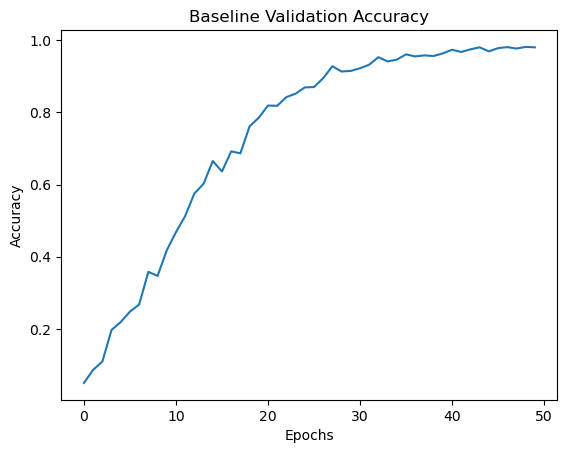

In [23]:
import matplotlib.pyplot as plt
plt.plot(val_accs,label='Val acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Baseline Validation Accuracy")

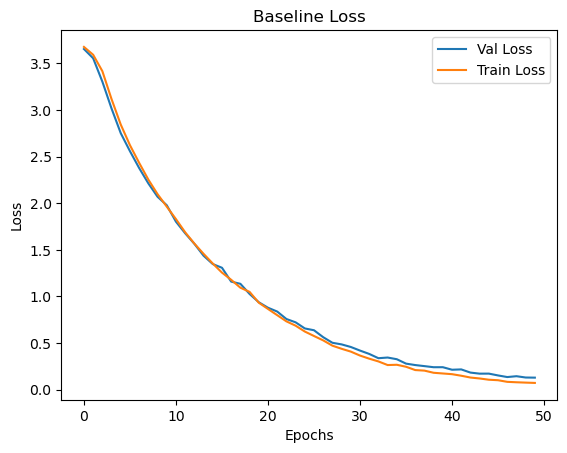

In [24]:
plt.plot(val_losses,label='Val Loss')
plt.plot(train_losses,label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Baseline Loss")
plt.legend()

In [25]:
print("Test Accuracy", test_acc)

Test Accuracy tensor(0.9819)


: 